# Grid Search using the whole Human Data

## Read Data

In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.model_selection import train_test_split

# Get data source.
simulated_results = r"D:\Users\91584\PycharmProjects\uitb-headsup-computing\huc\envs\mobile_reading\results\0817_0630_selection_results.csv"
human_duration_data = r"D:\Users\91584\PycharmProjects\uitb-headsup-computing\huc\envs\mobile_reading\results\human data\word selection duration.csv"
human_error_rate_data = r"D:\Users\91584\PycharmProjects\uitb-headsup-computing\huc\envs\mobile_reading\results\human data\word selection error rate.csv"

# Read in as dataframe.
df_simulations = pd.read_csv(simulated_results)
human_duration_df = pd.read_csv(human_duration_data)
human_error_rate_df = pd.read_csv(human_error_rate_data)

params = {
    'init_delta_t':None,
    'init_sigma_position_memory':None,
    'weight_memory_decay':None,
    'spatial_dist_coeff':None,
}

layouts = ['L0', 'L50', 'L100']
metrics = ['steps', 'error']

# Get individual-level human data
# human_data_steps_list = [1.572, 1.246, 1.032]    # L0, L50, L100
# human_data_error_list = [9.311, 4.275, 2.016]    # L0, L50, L100
human_duration_data = [human_duration_df[col].tolist() for col in human_duration_df.columns if col != "Participant"]
human_error_data = [human_error_rate_df[col].tolist() for col in human_error_rate_df.columns if col != "Participant"]

In [59]:
human_duration_data, len(human_duration_data), len(human_duration_data[0])

([[1.42, 1.13, 1.13, 4.23, 1.37, 1.81, 1.08, 1.45, 1.59, 1.79, 1.11, 0.75],
  [1.48, 1.94, 0.7, 3.19, 0.64, 1.23, 0.87, 1.11, 1.15, 1.13, 0.95, 0.56],
  [1.38, 1.11, 0.6, 3.36, 0.73, 0.83, 0.85, 0.96, 0.92, 0.78, 0.42, 0.44]],
 3,
 12)

In [60]:
human_error_data

[[15.46, 2.41, 6.36, 27.27, 3.92, 8.18, 2.0, 11.21, 0.73, 5.26, 10.92, 18.01],
 [2.99, 1.71, 2.96, 11.72, 0.0, 5.29, 1.45, 4.18, 1.98, 3.83, 10.31, 4.88],
 [3.29, 0.0, 0.84, 6.84, 0.91, 0.0, 0.6, 0.18, 0.47, 4.99, 2.12, 3.95]]

## Grid Search with the Loss Function of Summed Abs Difference

In [61]:
# Normalize a list
def normalize(lst):
    min_val = min(lst)
    max_val = max(lst)
    if min_val == max_val:  # Avoid division by zero
        return [0.5 for _ in lst]  # Return 0.5 (middle) if all values are same
    return [(x - min_val) / (max_val - min_val) for x in lst]

# Define the cost function
def compute_cost(sim_data, human_data):
    return sum(abs(sim - human) for sim, human in zip(sim_data, human_data))

# Get the mean values
mean_human_duration = [np.mean(data) for data in human_duration_data]
mean_human_error = [np.mean(data) for data in human_error_data]

# Normalize the human data
human_duration_norm = normalize(mean_human_duration)
human_error_norm = normalize(mean_human_error)

# Iterate through each unique parameter combination
unique_params = df_simulations.drop(columns=['layout', 'steps', 'error']).drop_duplicates()

min_cost = float('inf')
best_params = None

for index, row in unique_params.iterrows():
    # Filter the dataframe for the specific parameter combination
    filtered_df = df_simulations[
        (df_simulations['init_delta_t'] == row['init_delta_t']) &
        (df_simulations['init_sigma_position_memory'] == row['init_sigma_position_memory']) &
        (df_simulations['weight_memory_decay'] == row['weight_memory_decay']) &
        (df_simulations['spatial_dist_coeff'] == row['spatial_dist_coeff'])
    ]
    
    sim_duration = [filtered_df[filtered_df['layout'] == layout]['steps'].values[0] for layout in layouts]
    sim_error = [filtered_df[filtered_df['layout'] == layout]['error'].values[0] for layout in layouts]
    
    # Normalize the simulated data
    sim_duration_norm = normalize(sim_duration)
    sim_error_norm = normalize(sim_error)
    
    # Compute the cost
    cost_duration = compute_cost(sim_duration_norm, human_duration_norm)
    cost_error = compute_cost(sim_error_norm, human_error_norm)
    total_cost = cost_duration + cost_error

    # Update the best parameters if this cost is lower
    if total_cost < min_cost:
        min_cost = total_cost
        best_params = row
        
print("Best parameters:", best_params)

Best parameters: init_delta_t                  3.5
init_sigma_position_memory    0.5
weight_memory_decay           0.6
spatial_dist_coeff            2.5
Name: 6975, dtype: float64


## Get a sim-to-real-mapping-parameter to fit human data and Plot

In [62]:
# Using best_params, get the simulation data for steps and errors for the best parameters
best_df = df_simulations[
    (df_simulations['init_delta_t'] == best_params['init_delta_t']) &
    (df_simulations['init_sigma_position_memory'] == best_params['init_sigma_position_memory']) &
    (df_simulations['weight_memory_decay'] == best_params['weight_memory_decay']) &
    (df_simulations['spatial_dist_coeff'] == best_params['spatial_dist_coeff'])
]

sim_duration_best = [best_df[best_df['layout'] == layout]['steps'].values[0] for layout in layouts]
sim_error_best = [best_df[best_df['layout'] == layout]['error'].values[0] for layout in layouts]

sim_to_real_ratio_duration = sum(mean_human_duration) / sum(sim_duration_best)
sim_to_real_ratio_error = sum(mean_human_error) / sum(sim_error_best)

In [63]:
sim_duration_best

[10.56, 8.24, 6.72]

In [64]:
sim_to_real_ratio_duration, sim_to_real_ratio_error

(0.15082941483803552, 6.6108757062146895)

In [65]:
# Plot individual level data
import matplotlib.pyplot as plt

# Read in individual data
individual_data = r"C:\Users\91584\Desktop\0817_0630_selection_individual_data.csv"
individual_df = pd.read_csv(individual_data)

In [66]:
def extract_data(df, params, col_name, layouts):
    # Filter the dataframe based on the provided params
    for key, value in params.items():
        if isinstance(value, float):
            df = df[np.isclose(df[key], value, atol=1e-8)]
        else:
            df = df[df[key] == value]
    
    data = []
    for layout in layouts:
        subset = df[df['layout'] == layout][col_name].tolist()
        data.append(subset)
    return data

# Function to calculate means and standard error of the mean
def calculate_mean_and_sem(data):
    means = [np.mean(d) for d in data]
    sems = [np.std(d) / np.sqrt(len(d)) for d in data]
    return means, sems

def adjust_ylim(ax, bar_heights, sems):
    max_height = max(bar_heights)
    max_sem = max(sems)
    margin = max_height * 0.1  # Adjust as per requirement
    ax.set_ylim(0, max_height + max_sem + margin)

def plot_comparison_bars(sim_means, sim_sems, human_means, human_sems, title_prefix=""):
    fig, axs = plt.subplots(2, 1, figsize=(10, 12))

    x_labels = ["L0", "L50", "L100"]
    x = np.arange(len(x_labels))
    bar_width = 0.25

    # Plotting for Duration
    axs[0].bar(x - bar_width/2, sim_means[0], yerr=sim_sems[0], color='blue', width=bar_width, label='Simulator', capsize=5)
    axs[0].bar(x + bar_width/2, human_means[0], yerr=human_sems[0], color='orange', width=bar_width, label='Human', capsize=5)
    
    # Annotating Duration Bars
    for i, rect in enumerate(axs[0].patches):
        height = rect.get_height()
        if i < len(x_labels):
            sem = sim_sems[0][i]
        else:
            sem = human_sems[0][i-len(x_labels)]
        axs[0].annotate(f"{height:.2f}\n({sem:.2f})", 
                       (rect.get_x() + rect.get_width() / 2., height + sem + 0.05),
                       ha='center', va='bottom')

    # Styling for Duration
    axs[0].set_xlabel("Layouts", fontsize=12)
    axs[0].set_ylabel(f"{title_prefix} Duration Across Different Layouts (s)", fontsize=12)
    axs[0].set_xticks(x)
    axs[0].set_xticklabels(x_labels)
    axs[0].legend()

    # Plotting for Error Rate
    axs[1].bar(x - bar_width/2, sim_means[1], yerr=sim_sems[1], color='blue', width=bar_width, label='Simulator', capsize=5)
    axs[1].bar(x + bar_width/2, human_means[1], yerr=human_sems[1], color='orange', width=bar_width, label='Human', capsize=5)
    
    # Annotating Error Bars
    for i, rect in enumerate(axs[1].patches):
        height = rect.get_height()
        if i < len(x_labels):
            sem = sim_sems[1][i]
        else:
            sem = human_sems[1][i-len(x_labels)]
        axs[1].annotate(f"{height:.2f}%\n({sem:.2f}%)", 
                       (rect.get_x() + rect.get_width() / 2., height + sem + 0.05),
                       ha='center', va='bottom')

    # Styling for Error Rate
    axs[1].set_xlabel("Layouts", fontsize=12)
    axs[1].set_ylabel(f"{title_prefix} Error Rate Across Different Layouts (%)", fontsize=12)
    axs[1].set_xticks(x)
    axs[1].set_xticklabels(x_labels)
    axs[1].legend()
    
    # After plotting and annotating Duration bars, adjust the y-limit
    adjust_ylim(axs[0], sim_duration_mean + human_duration_mean, sim_duration_sem + human_duration_sem)

    # After plotting and annotating Error Rate bars, adjust the y-limit
    adjust_ylim(axs[1], sim_error_mean + human_error_mean, sim_error_sem + human_error_sem)


    plt.tight_layout()
    plt.show()

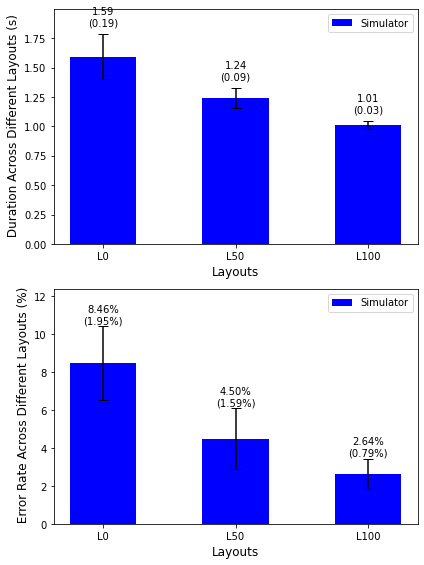

In [75]:
def plot_simulated_bars(sim_means, sim_sems, title_prefix=""):
    fig, axs = plt.subplots(2, 1, figsize=(6, 8))

    x_labels = ["L0", "L50", "L100"]
    x = np.arange(len(x_labels))
    bar_width = 0.5

    # Plotting for Duration
    axs[0].bar(x, sim_means[0], yerr=sim_sems[0], color='blue', width=bar_width, label='Simulator', capsize=5)
    
    # Annotating Duration Bars
    for i, rect in enumerate(axs[0].patches):
        height = rect.get_height()
        sem = sim_sems[0][i]
        axs[0].annotate(f"{height:.2f}\n({sem:.2f})", 
                       (rect.get_x() + rect.get_width() / 2., height + sem + 0.05),
                       ha='center', va='bottom')

    # Styling for Duration
    axs[0].set_xlabel("Layouts", fontsize=12)
    axs[0].set_ylabel(f"{title_prefix} Duration Across Different Layouts (s)", fontsize=12)
    axs[0].set_xticks(x)
    axs[0].set_xticklabels(x_labels)
    axs[0].legend()

    # Plotting for Error Rate
    axs[1].bar(x, sim_means[1], yerr=sim_sems[1], color='blue', width=bar_width, label='Simulator', capsize=5)
    
    # Annotating Error Bars
    for i, rect in enumerate(axs[1].patches):
        height = rect.get_height()
        sem = sim_sems[1][i]
        axs[1].annotate(f"{height:.2f}%\n({sem:.2f}%)", 
                       (rect.get_x() + rect.get_width() / 2., height + sem + 0.05),
                       ha='center', va='bottom')

    # Styling for Error Rate
    axs[1].set_xlabel("Layouts", fontsize=12)
    axs[1].set_ylabel(f"{title_prefix} Error Rate Across Different Layouts (%)", fontsize=12)
    axs[1].set_xticks(x)
    axs[1].set_xticklabels(x_labels)
    axs[1].legend()

    # After plotting and annotating Duration bars, adjust the y-limit
    adjust_ylim(axs[0], sim_duration_mean + human_duration_mean, sim_duration_sem + human_duration_sem)

    # After plotting and annotating Error Rate bars, adjust the y-limit
    adjust_ylim(axs[1], sim_error_mean + human_error_mean, sim_error_sem + human_error_sem) 

    plt.tight_layout()
    plt.show()

# Extract the data for each agent
simulation_durations = extract_data(individual_df, best_params, 'steps', layouts)
simulation_errors = extract_data(individual_df, best_params, 'error', layouts)
sim_durations = [[item * sim_to_real_ratio_duration for item in sublist] for sublist in simulation_durations]
sim_errors = [[item * sim_to_real_ratio_error for item in sublist] for sublist in simulation_errors]

sim_duration_mean, sim_duration_sem = calculate_mean_and_sem(sim_durations)
sim_error_mean, sim_error_sem = calculate_mean_and_sem(sim_errors)

# Plot
plot_simulated_bars([sim_duration_mean, sim_error_mean], 
                    [sim_duration_sem, sim_error_sem])

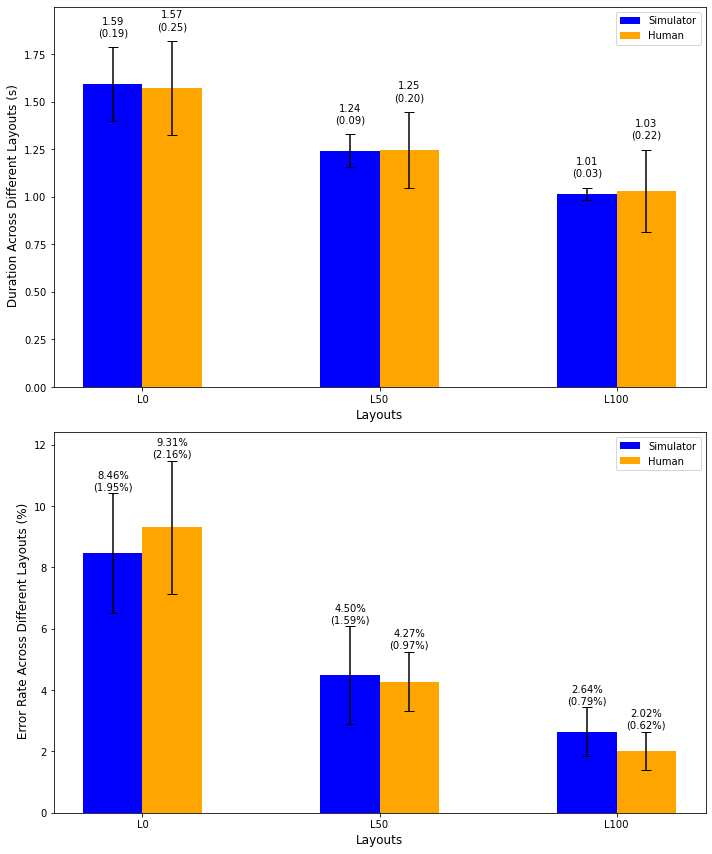

In [68]:
# Extract the data for each agent
simulation_durations = extract_data(individual_df, best_params, 'steps', layouts)
simulation_errors = extract_data(individual_df, best_params, 'error', layouts)
sim_durations = [[item * sim_to_real_ratio_duration for item in sublist] for sublist in simulation_durations]
sim_errors = [[item * sim_to_real_ratio_error for item in sublist] for sublist in simulation_errors]

sim_duration_mean, sim_duration_sem = calculate_mean_and_sem(sim_durations)
sim_error_mean, sim_error_sem = calculate_mean_and_sem(sim_errors)
human_duration_mean, human_duration_sem = calculate_mean_and_sem(human_duration_data)
human_error_mean, human_error_sem = calculate_mean_and_sem(human_error_data)

# Plot
plot_comparison_bars([sim_duration_mean, sim_error_mean], 
                     [sim_duration_sem, sim_error_sem], 
                     [human_duration_mean, human_error_mean], 
                     [human_duration_sem, human_error_sem])

## Comparison between human data and model's predictions - Need to downsample the simulated results

In [69]:
# Function to randomly select 12 indices from a list and sample from that list using those indices
def sample_twelve_indices(data):
    indices = np.arange(len(data))
    sampled_indices = np.random.choice(indices, 12, replace=False)
    return [data[i] for i in sampled_indices]

# Sample 12 items from sim_durations and sim_errors for each layout
sampled_sim_durations = []
sampled_sim_errors = []

for duration_subset, error_subset in zip(sim_durations, sim_errors):
    indices = np.arange(len(duration_subset))
    if len(indices) > 12:
        sampled_indices = np.random.choice(indices, 12, replace=False)
    else:
        sampled_indices = indices

    sampled_sim_durations.append([duration_subset[i] for i in sampled_indices])
    sampled_sim_errors.append([error_subset[i] for i in sampled_indices])

print(sampled_sim_durations)
print(sampled_sim_errors)

def compute_rmse(true_data, pred_data):
    assert len(true_data) == len(pred_data), "Data lengths must match"
    squared_errors = [(true - pred)**2 for true, pred in zip(true_data, pred_data)]
    return np.sqrt(np.mean(squared_errors))

# Assuming human_duration_data and human_error_data are the true values

rmse_durations = [compute_rmse(human, sim) for human, sim in zip(human_duration_data, sampled_sim_durations)]
rmse_errors = [compute_rmse(human, sim) for human, sim in zip(human_error_data, sampled_sim_errors)]

print("\n")
print("RMSE for Durations:", rmse_durations)
print("RMSE for Errors:", rmse_errors)

[[0.9049764890282131, 0.9049764890282131, 0.9049764890282131, 2.7149294670846396, 0.9049764890282131, 2.1116118077324972, 2.7149294670846396, 0.9049764890282131, 1.5082941483803554, 0.9049764890282131, 1.5082941483803554, 0.9049764890282131], [0.9049764890282131, 1.5082941483803554, 0.9049764890282131, 1.5082941483803554, 0.9049764890282131, 0.9049764890282131, 0.9049764890282131, 0.9049764890282131, 4.524882445141066, 0.9049764890282131, 0.9049764890282131, 1.5082941483803554], [0.9049764890282131, 0.9049764890282131, 0.9049764890282131, 1.5082941483803554, 0.9049764890282131, 0.9049764890282131, 1.5082941483803554, 1.5082941483803554, 0.9049764890282131, 0.9049764890282131, 0.9049764890282131, 0.9049764890282131]]
[[19.83262711864407, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 59.49788135593221, 0.0, 33.054378531073446, 0.0, 26.443502824858758], [0.0, 0.0, 6.6108757062146895, 0.0, 52.887005649717516, 0.0, 0.0, 6.6108757062146895, 52.887005649717516, 0.0, 13.221751412429379, 0.0], [0.0, 0.0, 6.610

## Comparison between human data and simulated results - Boostrapped

3 50
Bootstrapped RMSE for Durations: [1.9011334338148735, 1.054196566821754, 0.6338900704533129]
Bootstrapped RMSE for Errors: [14.346173514591715, 12.081788980616011, 5.662947092361292]


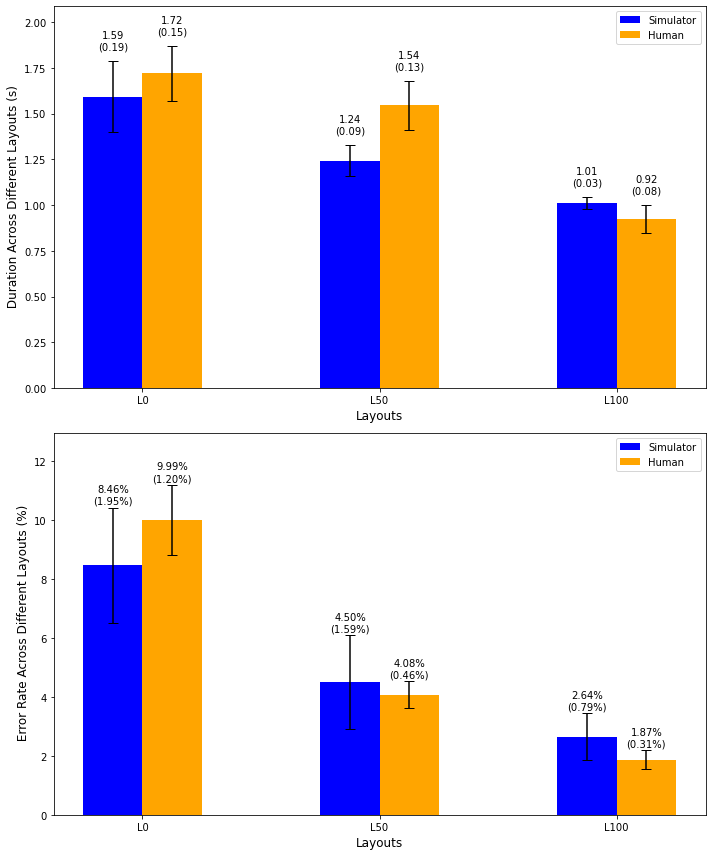

In [34]:
def bootstrap_resample(data, n):
    """ Bootstrap resample the data to have n points. """
    return np.random.choice(data, n, replace=True)

# Bootstrapping human data to match the length of simulated data
bootstrapped_human_durations = [bootstrap_resample(human, len(sim)) for human, sim in zip(human_duration_data, sim_durations)]
bootstrapped_human_errors = [bootstrap_resample(human, len(sim)) for human, sim in zip(human_error_data, sim_errors)]

print(len(bootstrapped_human_durations), len(bootstrapped_human_durations[0]))

# Computing RMSE for the bootstrapped data
rmse_durations_bootstrap = [compute_rmse(human, sim) for human, sim in zip(bootstrapped_human_durations, sim_durations)]
rmse_errors_bootstrap = [compute_rmse(human, sim) for human, sim in zip(bootstrapped_human_errors, sim_errors)]

print("Bootstrapped RMSE for Durations:", rmse_durations_bootstrap)
print("Bootstrapped RMSE for Errors:", rmse_errors_bootstrap)

# Plot
# Extract the data for each agent
sim_duration_mean, sim_duration_sem = calculate_mean_and_sem(sim_durations)
sim_error_mean, sim_error_sem = calculate_mean_and_sem(sim_errors)
human_duration_mean, human_duration_sem = calculate_mean_and_sem(bootstrapped_human_durations)
human_error_mean, human_error_sem = calculate_mean_and_sem(bootstrapped_human_errors)

# Plot
plot_comparison_bars([sim_duration_mean, sim_error_mean], 
                     [sim_duration_sem, sim_error_sem], 
                     [human_duration_mean, human_error_mean], 
                     [human_duration_sem, human_error_sem])

## Comparison between human data and simulated results - Aggregated mean and variance

In [24]:
def aggregate_comparison(human_data, simulated_data):
    # Compute aggregate metrics for human data
    human_mean = [np.mean(data) for data in human_data]
    human_sem = [np.std(data) / np.sqrt(len(data)) for data in human_data]

    # Compute aggregate metrics for simulated data
    simulated_mean = [np.mean(data) for data in simulated_data]
    simulated_sem = [np.std(data) / np.sqrt(len(data)) for data in simulated_data]

    return human_mean, human_sem, simulated_mean, simulated_sem

human_mean_duration, human_sem_duration, sim_mean_duration, sim_sem_duration = aggregate_comparison(human_duration_data, sim_durations)
human_mean_error, human_sem_error, sim_mean_error, sim_sem_error = aggregate_comparison(human_error_data, sim_errors)

print("Human vs Simulated Duration Mean:", human_mean_duration, sim_mean_duration)
print("Human vs Simulated Duration SEM:", human_sem_duration, sim_sem_duration)
print("Human vs Simulated Error Mean:", human_mean_error, sim_mean_error)
print("Human vs Simulated Error SEM:", human_sem_error, sim_sem_error)

Human vs Simulated Duration Mean: [1.5716666666666665, 1.2458333333333333, 1.0316666666666665] [1.5927586206896551, 1.242834378265413, 1.013573667711599]
Human vs Simulated Duration SEM: [0.24678722654380883, 0.19933729905939906, 0.21577970161632354] [0.19306919231613878, 0.08559459657640764, 0.032779642596439444]
Human vs Simulated Error Mean: [9.310833333333335, 4.2749999999999995, 2.015833333333333] [8.461920903954802, 4.495395480225989, 2.644350282485876]
Human vs Simulated Error SEM: [2.1608458536510056, 0.9680145057453083, 0.6235577340432762] [1.952526364653395, 1.5914507609254487, 0.7933050847457629]


## Comparison between human data and simulated results - Aggregated mean and variance

In [23]:
from scipy.stats import ks_2samp

def distribution_comparison(human_data, simulated_data):
    ks_statistic = []
    p_value = []

    for h_data, s_data in zip(human_data, simulated_data):
        ks_stat, p_val = ks_2samp(h_data, s_data)
        ks_statistic.append(ks_stat)
        p_value.append(p_val)

    return ks_statistic, p_value

ks_stat_duration, p_val_duration = distribution_comparison(human_duration_data, sim_durations)
ks_stat_error, p_val_error = distribution_comparison(human_error_data, sim_errors)

print("KS Statistic for Durations:", ks_stat_duration)
print("P-Value for Durations:", p_val_duration)
print("KS Statistic for Errors:", ks_stat_error)
print("P-Value for Errors:", p_val_error)

KS Statistic for Durations: [0.5166666666666667, 0.3333333333333333, 0.5833333333333334]
P-Value for Durations: [0.00644832985716548, 0.18442165557723567, 0.001199439791671808]
KS Statistic for Errors: [0.66, 0.6566666666666666, 0.5733333333333334]
P-Value for Errors: [0.0001273957725735908, 0.00016090361385778795, 0.0017484040152246916]


### Results explanation
The results of the Kolmogorov-Smirnov (KS) test give you both a test statistic (KS Statistic) and a corresponding p-value (P-Value). Here's how to interpret them:

1. KS Statistic:
The KS statistic represents the maximum difference between the cumulative distributions of the two datasets. Higher values of the KS statistic suggest that the two datasets are more dissimilar, while lower values suggest the datasets are more similar.

2. P-Value:
The p-value is a measure of the evidence against the null hypothesis. The null hypothesis of the KS test is that the two datasets come from the same continuous distribution.

A small p-value (typically ≤ 0.05) indicates that you can reject the null hypothesis. This means there's significant evidence that the distributions are different.

A large p-value suggests that the observed data is consistent with the null hypothesis, and there's no significant evidence to suggest the distributions are different.

Interpretation of Your Results:
Durations:
Layout 1: KS Statistic = 0.5167, P-Value = 0.0064: This suggests a significant difference between the human and simulated duration distributions.

Layout 2: KS Statistic = 0.3333, P-Value = 0.1844: The difference between the distributions is less pronounced than in Layout 1, and the p-value indicates that the difference is not statistically significant.

Layout 3: KS Statistic = 0.5833, P-Value = 0.0012: This again suggests a significant difference between the human and simulated duration distributions.

Errors:
Layout 1: KS Statistic = 0.66, P-Value = 0.00013: There's a significant difference between the human and simulated error distributions.

Layout 2: KS Statistic = 0.6567, P-Value = 0.00016: Again, there's a significant difference between the distributions.

Layout 3: KS Statistic = 0.5733, P-Value = 0.0017: There's still a significant difference between the two distributions.

Overall:
For most of the layouts, there's a statistically significant difference between the human data and the simulated data, both in durations and errors. Only for Layout 2 durations, the difference is not statistically significant. This suggests that while your model might be capturing some aspects of human behavior, there are still notable differences between the simulated and human data in the conditions tested.

# Grid Search using 50% Human Data, then Evaluate on other half

## Read Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.model_selection import train_test_split

# Get data source

# Reportable data
simulated_results = r"D:\Users\91584\PycharmProjects\uitb-headsup-computing\huc\envs\mobile_reading\results\0827_100m_50ep_selection_results.csv"
# Ablation study data
ablation_simulated_results = r"D:\Users\91584\PycharmProjects\uitb-headsup-computing\huc\envs\mobile_reading\results\0901_ablationstudy_100ep_selection_results.csv"
# simulated_results = r"D:\Users\91584\PycharmProjects\uitb-headsup-computing\huc\envs\mobile_reading\results\0904_100ep_100m_0dot5to1_readresumption_selection_results.csv"
human_duration_data = r"D:\Users\91584\PycharmProjects\uitb-headsup-computing\huc\envs\mobile_reading\results\human data\word selection duration.csv"
human_error_rate_data = r"D:\Users\91584\PycharmProjects\uitb-headsup-computing\huc\envs\mobile_reading\results\human data\word selection error rate.csv"

# Read in as dataframe.
df_simulations = pd.read_csv(simulated_results)
df_ablation_simulations = pd.read_csv(ablation_simulated_results)
human_duration_df = pd.read_csv(human_duration_data)
human_error_rate_df = pd.read_csv(human_error_rate_data)

params = {
    'init_delta_t':None,
    'init_sigma_position_memory':None,
    'weight_memory_decay':None,
    'spatial_dist_coeff':None,
}

layouts = ['L0', 'L50', 'L100']
metrics = ['steps', 'error']

# Get individual-level human data
# human_data_steps_list = [1.572, 1.246, 1.032]    # L0, L50, L100
# human_data_error_list = [9.311, 4.275, 2.016]    # L0, L50, L100
human_duration_data = [human_duration_df[col].tolist() for col in human_duration_df.columns if col != "Participant"]
human_error_data = [human_error_rate_df[col].tolist() for col in human_error_rate_df.columns if col != "Participant"]

In [2]:
human_duration_data

[[1.42, 1.13, 1.13, 4.23, 1.37, 1.81, 1.08, 1.45, 1.59, 1.79, 1.11, 0.75],
 [1.48, 1.94, 0.7, 3.19, 0.64, 1.23, 0.87, 1.11, 1.15, 1.13, 0.95, 0.56],
 [1.38, 1.11, 0.6, 3.36, 0.73, 0.83, 0.85, 0.96, 0.92, 0.78, 0.42, 0.44]]

In [3]:
human_error_data

[[15.46, 2.41, 6.36, 27.27, 3.92, 8.18, 2.0, 11.21, 0.73, 5.26, 10.92, 18.01],
 [2.99, 1.71, 2.96, 11.72, 0.0, 5.29, 1.45, 4.18, 1.98, 3.83, 10.31, 4.88],
 [3.29, 0.0, 0.84, 6.84, 0.91, 0.0, 0.6, 0.18, 0.47, 4.99, 2.12, 3.95]]

## Halve the human data into two parts - training and evaluation

In [62]:
prior_work_init_sigma_position_memory = 4.5
empirical_init_delta_time = 1

# Normalize a list
def normalize(lst):
    min_val = min(lst)
    max_val = max(lst)
    if min_val == max_val:  # Avoid division by zero
        return [0.5 for _ in lst]  # Return 0.5 (middle) if all values are same
    return [(x - min_val) / (max_val - min_val) for x in lst]

# Define the cost function
def compute_cost(sim_data, human_data):
    return sum(abs(sim - human) for sim, human in zip(sim_data, human_data))

def find_best_params(data, human_duration, human_error):
    # Filter the main dataframe to only consider rows where init_sigma_position_memory is 4.5
    data = data[
        (data['init_sigma_position_memory'] == prior_work_init_sigma_position_memory) 
        & (data['init_delta_t'] == empirical_init_delta_time)
    ]
    
    unique_params = data.drop(columns=['layout', 'steps', 'error']).drop_duplicates()
    min_cost = float('inf')
    best_params = None

    for index, row in unique_params.iterrows():
        filtered_df = data[
#             (data['init_delta_t'] == row['init_delta_t']) &
            # Comment this when trying to do pruned grid search
#             (data['init_sigma_position_memory'] == row['init_sigma_position_memory']) &
            (data['weight_memory_decay'] == row['weight_memory_decay']) &
            (data['spatial_dist_coeff'] == row['spatial_dist_coeff'])
        ]
        
        sim_steps = [filtered_df[filtered_df['layout'] == layout]['steps'].values[0] for layout in layouts]
        sim_error = [filtered_df[filtered_df['layout'] == layout]['error'].values[0] for layout in layouts]
        
        cost_steps = compute_cost(normalize(sim_steps), normalize(human_duration))
        cost_error = compute_cost(normalize(sim_error), normalize(human_error))
        
        total_cost = cost_steps + cost_error

        if total_cost < min_cost:
            min_cost = total_cost
            best_params = row
    
    # Given the best parameters and teh dataframe, return the simulated steps (durations) and errors for the three layouts
    sim_steps_best = []
    sim_errors_best = []
    
    # Extract the simulated steps and error for each layout based on best_params
    for layout in layouts:
        filtered_df = data[
#             (data['init_delta_t'] == best_params['init_delta_t']) &
            # Comment this when trying to do pruned grid search
#             (data['init_sigma_position_memory'] == best_params['init_sigma_position_memory']) &
            (data['weight_memory_decay'] == best_params['weight_memory_decay']) &
            (data['spatial_dist_coeff'] == best_params['spatial_dist_coeff']) &
            (data['layout'] == layout)
        ]
        
        sim_steps_best.append(filtered_df['steps'].values[0])
        sim_errors_best.append(filtered_df['error'].values[0])

    return best_params, min_cost, sim_steps_best, sim_errors_best

## Grid Search

In [69]:
%%time

num_iterations = 100
all_costs = []
all_best_params = []

# Lists to store sim-to-real mapping ratios for each iteration
sim_to_real_ratios_duration = []
sim_to_real_ratios_error = []

# Initialize dictionaries for storing results
simulated_durations = {'L0': [], 'L50': [], 'L100': []}
simulated_errors = {'L0': [], 'L50': [], 'L100': []}
human_train_durations = {'L0': [], 'L50': [], 'L100': []}
human_train_errors = {'L0': [], 'L50': [], 'L100': []}
human_test_durations = {'L0': [], 'L50': [], 'L100': []}
human_test_errors = {'L0': [], 'L50': [], 'L100': []}
human_train_durations_details = {'L0': [], 'L50': [], 'L100': []}  # Collect detailed data in each iterations, not aggregated
human_train_errors_details = {'L0': [], 'L50': [], 'L100': []}
human_test_durations_details = {'L0': [], 'L50': [], 'L100': []}
human_test_errors_details = {'L0': [], 'L50': [], 'L100': []}

for i in range(num_iterations):
    # Number of participants
    num_participants = len(human_duration_data[0])

    # Generate list of indices based on participants
    indices = list(range(num_participants))

    # Split indices to ensure consistency
    train_indices, test_indices = train_test_split(indices, test_size=0.5, random_state=i)  
    # using i as the seed for reproducibility

    # Use these indices to split the human data consistently across participants
    def split_data_based_on_indices(data, train_indices, test_indices):
        train_set = [data[i] for i in train_indices]
        test_set = [data[i] for i in test_indices]
        return train_set, test_set

    # Split human duration data
    train_duration = [split_data_based_on_indices(condition, train_indices, test_indices) for condition in human_duration_data]
    train_duration = list(zip(*train_duration))[0]  # Extracting the training data

    test_duration = [split_data_based_on_indices(condition, train_indices, test_indices) for condition in human_duration_data]
    test_duration = list(zip(*test_duration))[1]  # Extracting the test data

    # Split human error data
    train_error = [split_data_based_on_indices(condition, train_indices, test_indices) for condition in human_error_data]
    train_error = list(zip(*train_error))[0]  # Extracting the training data

    test_error = [split_data_based_on_indices(condition, train_indices, test_indices) for condition in human_error_data]
    test_error = list(zip(*test_error))[1]  # Extracting the test data

    # Compute mean for the training and test sets
    mean_train_duration = [np.mean(data) for data in train_duration]
    mean_train_error = [np.mean(data) for data in train_error]
    mean_test_duration = [np.mean(data) for data in test_duration]
    mean_test_error = [np.mean(data) for data in test_error]

    # Using the function to find the best parameters
    best_params, _, sim_durations, sim_errors = find_best_params(df_simulations, mean_train_duration, mean_train_error)
    all_best_params.append(best_params)
    
    # Get sim to real mapping ratios for duration and error metrics respectively
    # Compute sim-to-real ratio for the current iteration
    sim_to_real_ratio_duration = sum(mean_train_duration) / sum(sim_durations)
    sim_to_real_ratio_error = sum(mean_train_error) / sum(sim_errors)
    
    # Store the computed ratios
    sim_to_real_ratios_duration.append(sim_to_real_ratio_duration)
    sim_to_real_ratios_error.append(sim_to_real_ratio_error)
    
    for label, sd, se, ted, tee, trd, tre in zip(
        ['L0', 'L50', 'L100'], 
        sim_durations, 
        sim_errors, 
        test_duration, 
        test_error, 
        train_duration, 
        train_error,
    ):
        simulated_durations[label].append(sd)
        simulated_errors[label].append(se)
        human_train_durations[label].append(np.mean(trd))
        human_train_errors[label].append(np.mean(tre))
        human_test_durations[label].append(np.mean(ted))
        human_test_errors[label].append(np.mean(tee))
        human_train_durations_details[label].append(trd)
        human_train_errors_details[label].append(tre)
        human_test_durations_details[label].append(ted)
        human_test_errors_details[label].append(tee)

CPU times: total: 9.27 s
Wall time: 9.87 s


In [70]:
# Copy results for reproducibility
import copy

simulated_durations_copy = copy.deepcopy(simulated_durations)
simulated_errors_copy = copy.deepcopy(simulated_errors)
human_test_durations_copy = copy.deepcopy(human_test_durations)
human_test_errors_copy = copy.deepcopy(human_test_errors)
human_train_durations_copy = copy.deepcopy(human_train_durations)
human_train_errors_copy = copy.deepcopy(human_train_errors)
human_test_durations_details_copy = copy.deepcopy(human_test_durations_details)
human_test_errors_details_copy = copy.deepcopy(human_test_errors_details)
human_train_durations_details_copy = copy.deepcopy(human_train_durations_details)
human_train_errors_details_copy = copy.deepcopy(human_train_errors_details)

In [71]:
import csv
# Open a CSV file in write mode
best_params_file_name = "0906_normal_oneinitdeltat_4dot5sigmapm_train_test_split_repeats_data_rep100.csv"

In [72]:
# Write
with open(best_params_file_name, "w", newline='') as csvfile:
    # Initialize the CSV writer
    writer = csv.writer(csvfile)

    # Write the headers
    headers = [
        "Layout", 
        "Simulated Durations", 
        "Simulated Errors", 
        "Human Train Durations", 
        "Human Train Errors", 
        "Human Test Durations",
        "Human Test Errors",
        "init_delta_t", 
        "init_sigma_position_memory", 
        "weight_memory_decay", 
        "spatial_dist_coeff",
        "Sim to Real Ratio Duration",
        "Sim to Real Ratio Error"
    ]
    writer.writerow(headers)
    
    # Write data for each layout
    for i, best_param in enumerate(all_best_params):
        for label in ['L0', 'L50', 'L100']:
            row = [
                label, 
                simulated_durations[label][i], 
                simulated_errors[label][i], 
                human_train_durations[label][i], 
                human_train_errors[label][i],
                human_test_durations[label][i],
                human_test_errors[label][i],
                best_param[0],  # init_delta_t
                best_param[1],  # init_sigma_position_memory
                best_param[2],  # weight_memory_decay
                best_param[3],  # spatial_dist_coeff
                sim_to_real_ratios_duration[i],
                sim_to_real_ratios_error[i]
            ]
            writer.writerow(row)

## Data evaluation

In [73]:
import pandas as pd
import copy

# best_params_file_name = "0905_normal_noinitdeltat_4dot5sigmapm_train_test_split_repeats_data_rep500.csv"

# Read in the CSV file
data = pd.read_csv(best_params_file_name)

# Create dictionaries to store data by layout and type
simulated_durations = {'L0': [], 'L50': [], 'L100': []}
simulated_errors = {'L0': [], 'L50': [], 'L100': []}
human_train_durations = {'L0': [], 'L50': [], 'L100': []}
human_train_errors = {'L0': [], 'L50': [], 'L100': []}
human_test_durations = {'L0': [], 'L50': [], 'L100': []}
human_test_errors = {'L0': [], 'L50': [], 'L100': []}
sim_to_real_ratios_duration = {'L0': [], 'L50': [], 'L100': []}
sim_to_real_ratios_error = {'L0': [], 'L50': [], 'L100': []}
# sim_to_real_ratios_duration = []
# sim_to_real_ratios_error = []

# Iterate through each row in the dataset
for index, row in data.iterrows():
    layout = row['Layout']
    simulated_durations[layout].append(row['Simulated Durations'])
    simulated_errors[layout].append(row['Simulated Errors'])
    human_train_durations[layout].append(row['Human Train Durations'])
    human_train_errors[layout].append(row['Human Train Errors'])
    human_test_durations[layout].append(row['Human Test Durations'])
    human_test_errors[layout].append(row['Human Test Errors'])
    sim_to_real_ratios_duration[layout].append(row['Sim to Real Ratio Duration'])
    sim_to_real_ratios_error[layout].append(row['Sim to Real Ratio Error'])

num_iterations = int(data.shape[0] / 3)

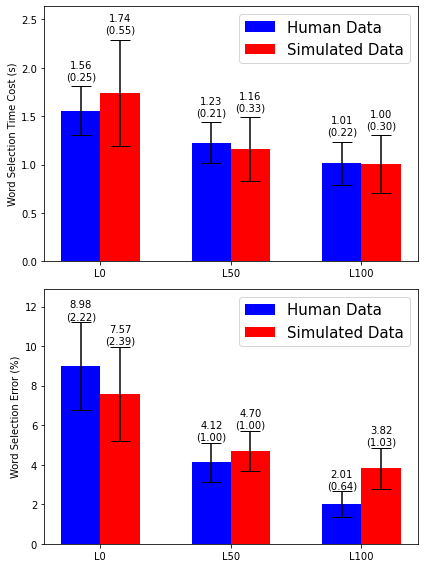

In [74]:
import matplotlib.pyplot as plt
import numpy as np

simulated_durations_copy = copy.deepcopy(simulated_durations)
simulated_errors_copy = copy.deepcopy(simulated_errors)
human_test_durations_copy = copy.deepcopy(human_test_durations)
human_test_errors_copy = copy.deepcopy(human_test_errors)
human_train_durations_copy = copy.deepcopy(human_train_durations)
human_train_errors_copy = copy.deepcopy(human_train_errors)

labels = ['L0', 'L50', 'L100']

# Calculate SEM
def std(data):
    return np.std(data) #/ np.sqrt(len(data))

# Function to adjust y-limit
def adjust_ylim(ax, means, sems):
    y_max = max([mean + sem for mean, sem in zip(means, sems)])
    ax.set_ylim(0, y_max * 1.15)  # Adding a bit of margin to the top

# Using the average results for the test set
mean_human_test_duration = [np.mean(human_test_durations_copy[label]) for label in labels]
std_human_test_duration = [std(human_test_durations_copy[label]) for label in labels]
mean_human_test_error = [np.mean(human_test_errors_copy[label]) for label in labels]
std_human_test_error = [std(human_test_errors_copy[label]) for label in labels]

# Adjust the simulated data with ratios
for iteration in range(num_iterations):
    for label in labels:
        simulated_durations_copy[label][iteration] *= sim_to_real_ratios_duration[layout][iteration]
        simulated_errors_copy[label][iteration] *= sim_to_real_ratios_error[layout][iteration]

# Now recompute the mean and sem for these adjusted simulated results
mean_simulated_duration = [np.mean(simulated_durations_copy[label]) for label in labels]
std_simulated_duration = [std(simulated_durations_copy[label]) for label in labels]
mean_simulated_error = [np.mean(simulated_errors_copy[label]) for label in labels]
std_simulated_error = [std(simulated_errors_copy[label]) for label in labels]

# Calculate 95% confidence interval ######################################################################
# def confidence_interval(data):
#     n = len(data)
#     mean = np.mean(data)
#     std_err = np.std(data) / np.sqrt(n)
    
#     # Assuming t-distribution (for n > 30 you can use 1.96 which is z-distribution for 95% CI)
#     confidence = 1.96
#     margin_of_error = std_err * confidence
#     return margin_of_error

# # Update the error computation for plotting
# std_human_test_duration = [confidence_interval(human_test_durations_copy[label]) for label in labels]
# std_simulated_duration = [confidence_interval(simulated_durations_copy[label]) for label in labels]
# std_human_test_error = [confidence_interval(human_test_errors_copy[label]) for label in labels]
# std_simulated_error = [confidence_interval(simulated_errors_copy[label]) for label in labels]

###########################################################################################################

# Update the plotting logic
x = np.arange(len(labels))
width = 0.3

fig, ax = plt.subplots(2, 1, figsize=(6, 8))

# Plot for Duration
rects1 = ax[0].bar(x - width/2, mean_human_test_duration, width, label='Human Data', color='blue', yerr=std_human_test_duration, capsize=10)
rects2 = ax[0].bar(x + width/2, mean_simulated_duration, width, label='Simulated Data', color='red', yerr=std_simulated_duration, capsize=10)

# Plot for Error
rects3 = ax[1].bar(x - width/2, mean_human_test_error, width, label='Human Data', color='blue', yerr=std_human_test_error, capsize=10)
rects4 = ax[1].bar(x + width/2, mean_simulated_error, width, label='Simulated Data', color='red', yerr=std_simulated_error, capsize=10)

# Annotating bars
for i, (rect1, rect2) in enumerate(zip(rects1, rects2)):
    height1 = rect1.get_height()
    height2 = rect2.get_height()
    std1 = std_human_test_duration[i]
    std2 = std_simulated_duration[i]
    ax[0].annotate(f"{height1:.2f}\n({std1:.2f})", 
                   (rect1.get_x() + rect1.get_width() / 2., height1 + std1 + 0.05),
                   ha='center', va='bottom')
    ax[0].annotate(f"{height2:.2f}\n({std2:.2f})", 
                   (rect2.get_x() + rect2.get_width() / 2., height2 + std2 + 0.05),
                   ha='center', va='bottom')

for i, (rect3, rect4) in enumerate(zip(rects3, rects4)):
    height3 = rect3.get_height()
    height4 = rect4.get_height()
    std3 = std_human_test_error[i]
    std4 = std_simulated_error[i]
    ax[1].annotate(f"{height3:.2f}\n({std3:.2f})", 
                   (rect3.get_x() + rect3.get_width() / 2., height3 + std3 + 0.05),
                   ha='center', va='bottom')
    ax[1].annotate(f"{height4:.2f}\n({std4:.2f})", 
                   (rect4.get_x() + rect4.get_width() / 2., height4 + std4 + 0.05),
                   ha='center', va='bottom')

# Labels, title, and custom x-axis tick labels
ax[0].set_ylabel('Word Selection Time Cost (s)')
ax[0].set_xticks(x)
ax[0].set_xticklabels(labels)
ax[0].legend(fontsize=15)
adjust_ylim(ax[0], mean_human_test_duration + mean_simulated_duration, std_human_test_duration + std_simulated_duration)

ax[1].set_ylabel('Word Selection Error (%)')
ax[1].set_xticks(x)
ax[1].set_xticklabels(labels)
ax[1].legend(fontsize=15)
adjust_ylim(ax[1], mean_human_test_error + mean_simulated_error, std_human_test_error + std_simulated_error)

fig.tight_layout()
plt.show()

### Save plots

In [20]:
fig_duration, ax_duration = plt.subplots(figsize=(6, 4))
rects1 = ax_duration.bar(x - width/2, mean_human_test_duration, width, label='Human Data', color='blue', yerr=std_human_test_duration, capsize=10)
rects2 = ax_duration.bar(x + width/2, mean_simulated_duration, width, label='Simulated Data', color='red', yerr=std_simulated_duration, capsize=10)

# Annotations for Duration plot
for i, (rect1, rect2) in enumerate(zip(rects1, rects2)):
    height1 = rect1.get_height()
    height2 = rect2.get_height()
    std1 = std_human_test_duration[i]
    std2 = std_simulated_duration[i]
    ax_duration.annotate(f"{height1:.2f}\n({std1:.2f})", 
                   (rect1.get_x() + rect1.get_width() / 2., height1 + std1 + 0.05),
                   ha='center', va='bottom')
    ax_duration.annotate(f"{height2:.2f}\n({std2:.2f})", 
                   (rect2.get_x() + rect2.get_width() / 2., height2 + std2 + 0.05),
                   ha='center', va='bottom')

# Labels for Duration plot
ax_duration.set_ylabel('Reading Resumption Time (s)', fontsize=14)
ax_duration.set_xticks(x)
ax_duration.set_xticklabels(labels, fontsize=12, fontweight='bold')
ax_duration.tick_params(axis='y', labelsize=14)  # Adjust the fontsize as desired for y-axis

ax_duration.legend(fontsize=15)
adjust_ylim(ax_duration, mean_human_test_duration + mean_simulated_duration, std_human_test_duration + std_simulated_duration)

# Also, if you want the axis tick numbers to be larger:
ax_duration.tick_params(axis='both', labelsize=12)

fig_duration.tight_layout()
fig_duration.savefig('initdeltat1_sigmapm4dot5_reading_resumption/taskresumptiontimecost.png', dpi=300)
plt.close(fig_duration)

In [21]:
fig_error, ax_error = plt.subplots(figsize=(6, 4))
rects3 = ax_error.bar(x - width/2, mean_human_test_error, width, label='Human Data', color='blue', yerr=std_human_test_error, capsize=10)
rects4 = ax_error.bar(x + width/2, mean_simulated_error, width, label='Simulated Data', color='red', yerr=std_simulated_error, capsize=10)

# Annotations for Error plot
for i, (rect3, rect4) in enumerate(zip(rects3, rects4)):
    height3 = rect3.get_height()
    height4 = rect4.get_height()
    std3 = std_human_test_error[i]
    std4 = std_simulated_error[i]
    ax_error.annotate(f"{height3:.2f}\n({std3:.2f})", 
                   (rect3.get_x() + rect3.get_width() / 2., height3 + std3 + 0.05),
                   ha='center', va='bottom')
    ax_error.annotate(f"{height4:.2f}\n({std4:.2f})", 
                   (rect4.get_x() + rect4.get_width() / 2., height4 + std4 + 0.05),
                   ha='center', va='bottom')

# Labels for Error plot
ax_error.set_ylabel('Reading Resumption Error Rate (%)', fontsize=14)
ax_error.tick_params(axis='y', labelsize=14)  # Adjust the fontsize as desired for y-axis
ax_error.set_xticks(x)
ax_error.set_xticklabels(labels, fontsize=12, fontweight='bold')
ax_error.legend(fontsize=15)
adjust_ylim(ax_error, mean_human_test_error + mean_simulated_error, std_human_test_error + std_simulated_error)

# Also, if you want the axis tick numbers to be larger:
ax_duration.tick_params(axis='both', labelsize=12)

fig_error.tight_layout()
fig_error.savefig('initdeltat1_sigmapm4dot5_reading_resumption/taskresumptionerrorrate', dpi=300)
plt.close(fig_error)

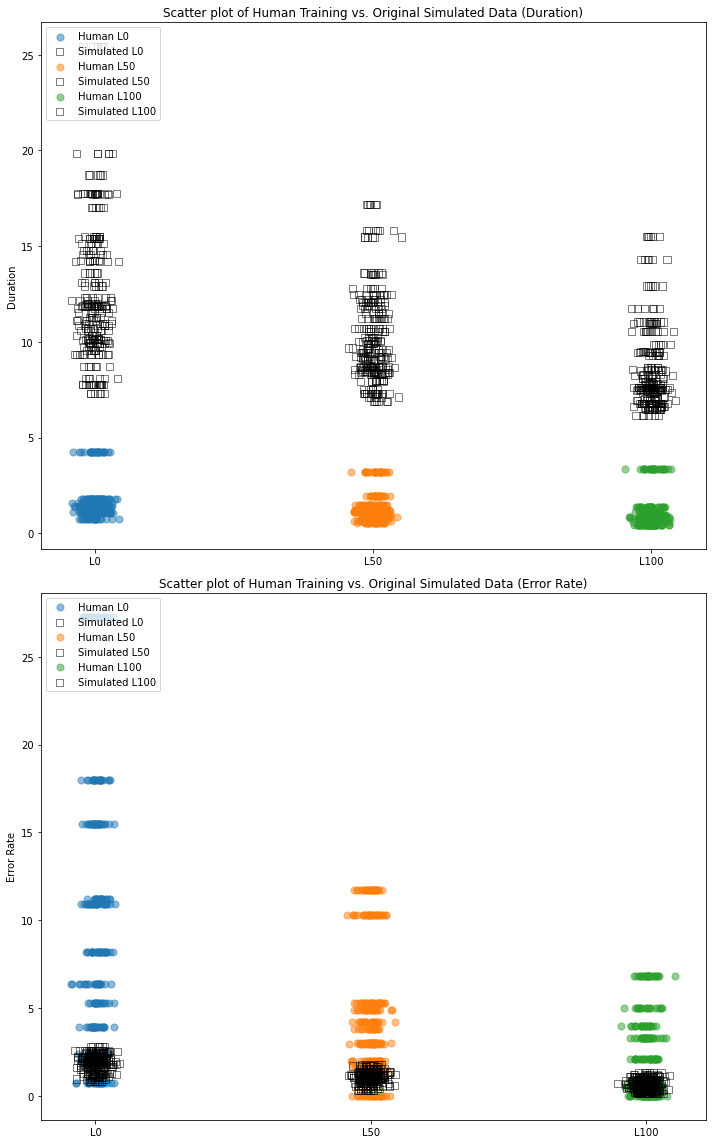

In [108]:
# import numpy as np
# import matplotlib.pyplot as plt

# # Create a function to generate scatter plot for each layout
# def plot_data_for_layout(layout, human_data, sim_data, ax, y_label):
#     # X values (adding a small random noise to x-values to prevent overlap)
#     x_vals_human = np.random.normal(loc=np.where(labels == layout)[0], scale=0.03, size=len(human_data))
#     x_vals_sim = np.random.normal(loc=np.where(labels == layout)[0], scale=0.03, size=len(sim_data))
    
#     ax.scatter(x_vals_human, human_data, marker='o', alpha=0.5, s=50, label=f"Human {layout}")
#     ax.scatter(x_vals_sim, sim_data, marker='s', edgecolor='black', facecolor='none', alpha=0.5, s=50, label=f"Simulated {layout}")

# # Create labels for the x-axis
# labels = np.array(['L0', 'L50', 'L100'])

# # Setup plots
# fig, axs = plt.subplots(2, 1, figsize=(10, 16))

# # Duration scatter plot
# for label in ['L0', 'L50', 'L100']:
#     human_data_duration = [val for sublist in human_train_durations_details[label] for val in sublist]
#     simulated_data_duration = simulated_durations[label] * len(human_train_durations_details[label][0])
#     plot_data_for_layout(label, human_data_duration, simulated_data_duration, axs[0], 'Duration')

# # Error scatter plot
# for label in ['L0', 'L50', 'L100']:
#     human_data_error = [val for sublist in human_train_errors_details[label] for val in sublist]
#     simulated_data_error = simulated_errors[label] * len(human_train_errors_details[label][0])
#     plot_data_for_layout(label, human_data_error, simulated_data_error, axs[1], 'Error Rate')

# # Set labels, ticks, and titles
# axs[0].set_xticks([0, 1, 2])
# axs[0].set_xticklabels(['L0', 'L50', 'L100'])
# axs[0].set_ylabel('Duration')
# axs[0].set_title('Scatter plot of Human Training vs. Original Simulated Data (Duration)')
# axs[0].legend(loc="upper left")

# axs[1].set_xticks([0, 1, 2])
# axs[1].set_xticklabels(['L0', 'L50', 'L100'])
# axs[1].set_ylabel('Error Rate')
# axs[1].set_title('Scatter plot of Human Training vs. Original Simulated Data (Error Rate)')
# axs[1].legend(loc="upper left")

# plt.tight_layout()
# plt.show()


### RSME

In [75]:
import pandas as pd

# Read in the CSV file
data = pd.read_csv(best_params_file_name)

# Create dictionaries to store data by layout and type
simulated_durations = {'L0': [], 'L50': [], 'L100': []}
simulated_errors = {'L0': [], 'L50': [], 'L100': []}
human_train_durations = {'L0': [], 'L50': [], 'L100': []}
human_train_errors = {'L0': [], 'L50': [], 'L100': []}
human_test_durations = {'L0': [], 'L50': [], 'L100': []}
human_test_errors = {'L0': [], 'L50': [], 'L100': []}
sim_to_real_ratios_duration = {'L0': [], 'L50': [], 'L100': []}
sim_to_real_ratios_error = {'L0': [], 'L50': [], 'L100': []}
# sim_to_real_ratios_duration = []
# sim_to_real_ratios_error = []

# Iterate through each row in the dataset
for index, row in data.iterrows():
    layout = row['Layout']
    simulated_durations[layout].append(row['Simulated Durations'])
    simulated_errors[layout].append(row['Simulated Errors'])
    human_train_durations[layout].append(row['Human Train Durations'])
    human_train_errors[layout].append(row['Human Train Errors'])
    human_test_durations[layout].append(row['Human Test Durations'])
    human_test_errors[layout].append(row['Human Test Errors'])
    sim_to_real_ratios_duration[layout].append(row['Sim to Real Ratio Duration'])
    sim_to_real_ratios_error[layout].append(row['Sim to Real Ratio Error'])

num_iterations = int(data.shape[0] / 3)

In [76]:
# Get rsme
simulated_durations_copy = copy.deepcopy(simulated_durations)
simulated_errors_copy = copy.deepcopy(simulated_errors)
human_test_durations_copy = copy.deepcopy(human_test_durations)
human_test_errors_copy = copy.deepcopy(human_test_errors)
human_train_durations_copy = copy.deepcopy(human_train_durations)
human_train_errors_copy = copy.deepcopy(human_train_errors)
human_test_durations_details_copy = copy.deepcopy(human_test_durations_details)
human_test_errors_details_copy = copy.deepcopy(human_test_errors_details)
human_train_durations_details_copy = copy.deepcopy(human_train_durations_details)
human_train_errors_details_copy = copy.deepcopy(human_train_errors_details)


# Adjust the simulated data with ratios
for iteration in range(num_iterations):
    for label in labels:
        simulated_durations_copy[label][iteration] *= sim_to_real_ratios_duration[label][iteration]
        simulated_errors_copy[label][iteration] *= sim_to_real_ratios_error[label][iteration]

# RMSE computation function
def compute_rmse(true_vals, predicted_vals):
    return np.sqrt(np.mean((np.array(true_vals) - np.array(predicted_vals)) ** 2))

# Compute RMSE for durations and errors for each layout
rmse_durations_layouts = {}
rmse_errors_layouts = {}

for label in labels:
    rmse_durations_layouts[label] = compute_rmse(human_test_durations_copy[label], simulated_durations_copy[label])
    rmse_errors_layouts[label] = compute_rmse(human_test_errors_copy[label], simulated_errors_copy[label])

# Average RMSE across all layouts
avg_rmse_durations = np.mean(list(rmse_durations_layouts.values()))
avg_rmse_errors = np.mean(list(rmse_errors_layouts.values()))

# Display results
print(f"Average RMSE between simulated durations and human test durations: {avg_rmse_durations:.4f}")
print(f"Average RMSE between simulated errors and human test errors: {avg_rmse_errors:.4f}")
for label in labels:
    print(f"RMSE for {label} - Durations: {rmse_durations_layouts[label]:.4f}, Errors: {rmse_errors_layouts[label]:.4f}")


Average RMSE between simulated durations and human test durations: 0.5785
Average RMSE between simulated errors and human test errors: 3.0017
RMSE for L0 - Durations: 0.7503, Errors: 4.6626
RMSE for L50 - Durations: 0.5124, Errors: 2.0259
RMSE for L100 - Durations: 0.4728, Errors: 2.3166


# Ablation Study

### The Re-trained Model

In [4]:
import pandas as pd
import numpy as np

# With the re-trained model:
# Reportable data
normal_simulated_results = r"D:\Users\91584\PycharmProjects\uitb-headsup-computing\huc\envs\mobile_reading\results\0827_100m_50ep_selection_results.csv"
# Ablation study data
ablation_simulated_results = r"D:\Users\91584\PycharmProjects\uitb-headsup-computing\huc\envs\mobile_reading\results\0901_ablationstudy_100ep_selection_results.csv"

# Parameter inferenced simulation + human data with train-test splits
best_params_file_name = "0906_normal_oneinitdeltat_4dot5sigmapm_train_test_split_repeats_data_rep500.csv"

df_ablation_simulations = pd.read_csv(ablation_simulated_results)

# Define a function to get ablation data based on parameters
def get_ablation_data(df, params):
    condition = (df['init_delta_t'] == params[0]) & \
                (df['init_sigma_position_memory'] == params[1]) & \
                (df['weight_memory_decay'] == params[2]) & \
                (df['spatial_dist_coeff'] == params[3])
    filtered_df = df[condition]
    # Assuming the ablation dataset has columns for 'duration' and 'error'
    durations = filtered_df['steps'].tolist()
    errors = filtered_df['error'].tolist()
    return durations, errors

extended_file_name = "0906_extended_normal_oneinitdeltat_4dot5sigmapm_train_test_split_repeats_data_rep500.csv"

# Read the existing data from the best_params_file_name
df_best_params = pd.read_csv(best_params_file_name)

# Modify the dataframe to add columns for ablation data
df_best_params["Ablation Durations"] = np.nan
df_best_params["Ablation Errors"] = np.nan

# Update the dataframe rows with ablation data based on the best parameters
for i, row in df_best_params.iterrows():
    best_param = (
        row["init_delta_t"],
        row["init_sigma_position_memory"],
        row["weight_memory_decay"],
        row["spatial_dist_coeff"],
    )
    ablation_durations, ablation_errors = get_ablation_data(df_ablation_simulations, best_param)
    
    # Here, I'm assuming that the ablation data results in one value for each label ('L0', 'L50', 'L100')
    # and so we're directly updating the dataframe's ablation columns. Adjust as necessary.
    df_best_params.at[i, "Ablation Durations"] = ablation_durations[0]  # or whichever index corresponds to the label
    df_best_params.at[i, "Ablation Errors"] = ablation_errors[0]

# Write the modified dataframe to the extended_file_name
df_best_params.to_csv(extended_file_name, index=False)

In [5]:
from scipy.stats import ttest_rel
import pandas as pd

# Load the extended dataset
df = pd.read_csv(extended_file_name)

# Define a function to test significance
def test_significance(simulated_data, ablation_data):
    t_stat, p_value = ttest_rel(simulated_data, ablation_data)
    return p_value

layouts = ['L0', 'L50', 'L100']
significance_results = {'Layout': [], 'Metric': [], 'p-value': []}

for layout in layouts:
    # For durations
    simulated_durations = df[df['Layout'] == layout]['Simulated Durations'].tolist()
    ablation_durations = df[df['Layout'] == layout]['Ablation Durations'].tolist()
    p_value_duration = test_significance(simulated_durations, ablation_durations)
    
    # For error rates
    simulated_errors = df[df['Layout'] == layout]['Simulated Errors'].tolist()
    ablation_errors = df[df['Layout'] == layout]['Ablation Errors'].tolist()
    p_value_error = test_significance(simulated_errors, ablation_errors)
    
    # Store the results
    significance_results['Layout'].append(layout)
    significance_results['Metric'].append('Duration')
    significance_results['p-value'].append(p_value_duration)
    
    significance_results['Layout'].append(layout)
    significance_results['Metric'].append('Error Rate')
    significance_results['p-value'].append(p_value_error)

# Convert to a DataFrame for easier handling
df_significance = pd.DataFrame(significance_results)

print(df_significance)


  Layout      Metric        p-value
0     L0    Duration   0.000000e+00
1     L0  Error Rate  8.377117e-286
2    L50    Duration  4.457257e-177
3    L50  Error Rate  4.738190e-267
4   L100    Duration  1.342395e-173
5   L100  Error Rate  4.628134e-269


In [6]:
# Read the data
df = pd.read_csv(extended_file_name)
df

,Layout,Simulated Durations,Simulated Errors,Human Train Durations,Human Train Errors,Human Test Durations,Human Test Errors,init_delta_t,init_sigma_position_memory,weight_memory_decay,spatial_dist_coeff,Sim to Real Ratio Duration,Sim to Real Ratio Error,Ablation Durations,Ablation Errors
0,L0,64.24,1.06,1.971667,11.631667,1.171667,6.990000,1.0,4.5,0.55,5.0,0.029257,7.166667,6.0,3.40
1,L50,59.26,0.83,1.680000,4.953333,0.811667,3.596667,1.0,4.5,0.55,5.0,0.029257,7.166667,6.0,3.40
2,L100,49.28,0.78,1.403333,2.550000,0.660000,1.481667,1.0,4.5,0.55,5.0,0.029257,7.166667,6.0,3.40
3,L0,63.46,1.29,1.468333,9.808333,1.675000,8.813333,1.0,4.5,0.90,4.5,0.022475,6.935673,6.0,4.19
4,L50,47.08,0.57,1.110000,3.858333,1.381667,4.691667,1.0,4.5,0.90,4.5,0.022475,6.935673,6.0,4.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,L50,47.08,0.57,1.123333,3.045000,1.368333,5.505000,1.0,4.5,0.90,4.5,0.023545,5.326754,6.0,4.19
1496,L100,43.56,0.42,0.933333,1.640000,1.130000,2.391667,1.0,4.5,0.90,4.5,0.023545,5.326754,6.0,4.19
1497,L0,64.24,1.06,1.420000,7.633333,1.723333,10.988333,1.0,4.5,0.55,5.0,0.019948,4.822722,6.0,3.40
1498,L50,59.26,0.83,1.186667,3.645000,1.305000,4.905000,1.0,4.5,0.55,5.0,0.019948,4.822722,6.0,3.40


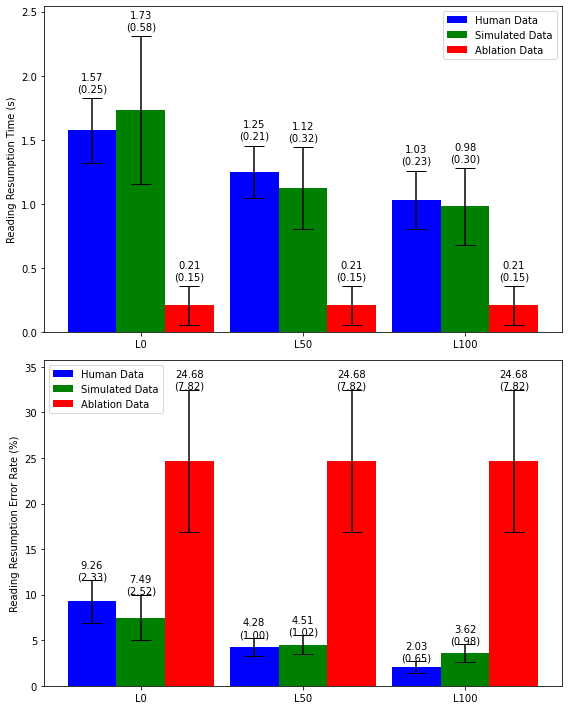

In [12]:
import matplotlib.pyplot as plt

alpha = 0.05

# Reorder the data based on the desired order of the Layouts
df = df.set_index('Layout').loc[['L0', 'L50', 'L100']].reset_index()

labels = ['L0', 'L50', 'L100']
Lables_index = {
    'L0':0,
    'L50':1,
    'L100':2,
}
    
## Using list comprehension to create nested lists based on Layout
human_test_durations = [df[df['Layout'] == layout]['Human Test Durations'].tolist() for layout in labels]
human_test_errors = [df[df['Layout'] == layout]['Human Test Errors'].tolist() for layout in labels]
simulated_durations = [df[df['Layout'] == layout]['Simulated Durations'].tolist() for layout in labels]
simulated_errors = [df[df['Layout'] == layout]['Simulated Errors'].tolist() for layout in labels]
ablation_durations = [df[df['Layout'] == layout]['Ablation Durations'].tolist() for layout in labels]
ablation_errors = [df[df['Layout'] == layout]['Ablation Errors'].tolist() for layout in labels]
sim_to_real_ratios_duration = [df[df['Layout'] == layout]['Sim to Real Ratio Duration'].tolist() for layout in labels]
sim_to_real_ratios_error = [df[df['Layout'] == layout]['Sim to Real Ratio Error'].tolist() for layout in labels]

# Compute the mean and std for human test data
mean_human_test_duration = [np.mean(human_test_durations[Lables_index[label]]) for label in labels]
std_human_test_duration = [np.std(human_test_durations[Lables_index[label]]) for label in labels]
mean_human_test_error = [np.mean(human_test_errors[Lables_index[label]]) for label in labels]
std_human_test_error = [np.std(human_test_errors[Lables_index[label]]) for label in labels]

# Adjust the simulated and ablation data with ratios
for i, label in enumerate(labels):
    simulated_durations[i] = [sd * ratio for sd, ratio in zip(simulated_durations[i], sim_to_real_ratios_duration[i])]
    simulated_errors[i] = [se * ratio for se, ratio in zip(simulated_errors[i], sim_to_real_ratios_error[i])]
    ablation_durations[i] = [ad * ratio for ad, ratio in zip(ablation_durations[i], sim_to_real_ratios_duration[i])]
    ablation_errors[i] = [ae * ratio for ae, ratio in zip(ablation_errors[i], sim_to_real_ratios_error[i])]

# Compute the mean and std for original simulated data
mean_simulated_duration = [np.mean(simulated_durations[Lables_index[label]]) for label in labels]
std_simulated_duration = [np.std(simulated_durations[Lables_index[label]]) for label in labels]
mean_simulated_error = [np.mean(simulated_errors[Lables_index[label]]) for label in labels]
std_simulated_error = [np.std(simulated_errors[Lables_index[label]]) for label in labels]

# Compute the mean and standard deviation for ablation data
mean_ablation_duration = [np.mean(ablation_durations[Lables_index[label]]) for label in labels]
std_ablation_duration = [np.std(ablation_durations[Lables_index[label]]) for label in labels]
mean_ablation_error = [np.mean(ablation_errors[Lables_index[label]]) for label in labels]
std_ablation_error = [np.std(ablation_errors[Lables_index[label]]) for label in labels]
    
# Update the plotting logic with added space for the ablation bars
x = np.arange(len(labels))
width = 0.3

fig, ax = plt.subplots(2, 1, figsize=(8, 10))

# Plot for Duration
ax[0].bar(x - width, mean_human_test_duration, width, label='Human Data', color='blue', yerr=std_human_test_duration, capsize=10)
ax[0].bar(x, mean_simulated_duration, width, label='Simulated Data', color='green', yerr=std_simulated_duration, capsize=10)
ax[0].bar(x + width, mean_ablation_duration, width, label='Ablation Data', color='red', yerr=std_ablation_duration, capsize=10)

# Plot for Error
ax[1].bar(x - width, mean_human_test_error, width, label='Human Data', color='blue', yerr=std_human_test_error, capsize=10)
ax[1].bar(x, mean_simulated_error, width, label='Simulated Data', color='green', yerr=std_simulated_error, capsize=10)
ax[1].bar(x + width, mean_ablation_error, width, label='Ablation Data', color='red', yerr=std_ablation_error, capsize=10)

leviation_offset = 0.05

# Annotations for Duration bars
for idx in x:
    h = mean_human_test_duration[idx]
    s = mean_simulated_duration[idx]
    a = mean_ablation_duration[idx]

    std_h = std_human_test_duration[idx]
    std_s = std_simulated_duration[idx]
    std_a = std_ablation_duration[idx]

    ax[0].annotate(f"{h:.2f}\n({std_h:.2f})", xy=(idx - width, h + std_h + leviation_offset), ha='center')
    ax[0].annotate(f"{s:.2f}\n({std_s:.2f})", xy=(idx, s + std_s + leviation_offset), ha='center')
    ax[0].annotate(f"{a:.2f}\n({std_a:.2f})", xy=(idx + width, a + std_a + leviation_offset), ha='center')

# Annotations for Error bars
for idx in x:
    h = mean_human_test_error[idx]
    s = mean_simulated_error[idx]
    a = mean_ablation_error[idx]

    std_h = std_human_test_error[idx]
    std_s = std_simulated_error[idx]
    std_a = std_ablation_error[idx]
    
    ax[1].annotate(f"{h:.2f}\n({std_h:.2f})", xy=(idx - width, h + std_h + leviation_offset), ha='center')
    ax[1].annotate(f"{s:.2f}\n({std_s:.2f})", xy=(idx, s + std_s + leviation_offset), ha='center')
    ax[1].annotate(f"{a:.2f}\n({std_a:.2f})", xy=(idx + width, a + std_a + leviation_offset), ha='center')

    
# Calculate the maximum value with error for Duration and set y-limit accordingly
max_val_duration = max(
    [m + s for m, s in zip(mean_simulated_duration, std_simulated_duration)] + 
    [m + s for m, s in zip(mean_ablation_duration, std_ablation_duration)]
)
ax[0].set_ylim(0, max_val_duration * 1.1)  # Using 1.1 gives 10% padding at the top

# Calculate the maximum value with error for Error and set y-limit accordingly
max_val_error = max(
    [m + s for m, s in zip(mean_simulated_error, std_simulated_error)] + 
    [m + s for m, s in zip(mean_ablation_error, std_ablation_error)]
)
ax[1].set_ylim(0, max_val_error * 1.1)  # Using 1.1 gives 10% padding at the top

# Setting the xticks, labels, title, legend for Duration subplot
ax[0].set_xticks(x)
ax[0].set_xticklabels(labels)
ax[0].set_ylabel('Reading Resumption Time (s)')
# ax[0].set_title('Duration Comparisons')
ax[0].legend()

# Setting the xticks, labels, title, legend for Error subplot
ax[1].set_xticks(x)
ax[1].set_xticklabels(labels)
ax[1].set_ylabel('Reading Resumption Error Rate (%)')
# ax[1].set_title('Error Comparisons')
ax[1].legend()

fig.tight_layout()
plt.show()

In [8]:
# RMSE
# Compute RMSE for ablation durations and errors for each layout
rmse_ablation_durations_layouts = {}
rmse_ablation_errors_layouts = {}

# RMSE computation function
def compute_rmse(true_vals, predicted_vals):
    return np.sqrt(np.mean((np.array(true_vals) - np.array(predicted_vals)) ** 2))

for i, label in enumerate(labels):
    rmse_ablation_durations_layouts[label] = compute_rmse(human_test_durations[i], ablation_durations[i])
    rmse_ablation_errors_layouts[label] = compute_rmse(human_test_errors[i], ablation_errors[i])

# Average RMSE across all layouts for ablation data
avg_rmse_ablation_durations = np.mean(list(rmse_ablation_durations_layouts.values()))
avg_rmse_ablation_errors = np.mean(list(rmse_ablation_errors_layouts.values()))

# Display results for ablation data
print(f"\nAverage RMSE between ablation durations and human test durations: {avg_rmse_ablation_durations:.4f}")
print(f"Average RMSE between ablation errors and human test errors: {avg_rmse_ablation_errors:.4f}")
for label in labels:
    print(f"RMSE for {label} (Ablation) - Durations: {rmse_ablation_durations_layouts[label]:.4f}, Errors: {rmse_ablation_errors_layouts[label]:.4f}")


Average RMSE between ablation durations and human test durations: 1.1195
Average RMSE between ablation errors and human test errors: 21.5212
RMSE for L0 (Ablation) - Durations: 1.4062, Errors: 18.3181
RMSE for L50 (Ablation) - Durations: 1.0751, Errors: 22.1193
RMSE for L100 (Ablation) - Durations: 0.8772, Errors: 24.1261


In [19]:
fig1, ax1 = plt.subplots(figsize=(6, 4))

# Plot for Duration
ax1.bar(x - width, mean_human_test_duration, width, label='Human Data', color='blue', yerr=std_human_test_duration, capsize=10)
ax1.bar(x, mean_simulated_duration, width, label='Simulated Data with MDM', color='green', yerr=std_simulated_duration, capsize=10)
ax1.bar(x + width, mean_ablation_duration, width, label='Simulated Data without MDM', color='red', yerr=std_ablation_duration, capsize=10)

leviation_offset_duration = 0.05

# Annotations for Duration bars
for idx in x:
    h = mean_human_test_duration[idx]
    s = mean_simulated_duration[idx]
    a = mean_ablation_duration[idx]
    std_h = std_human_test_duration[idx]
    std_s = std_simulated_duration[idx]
    std_a = std_ablation_duration[idx]
    
    ax1.annotate(f"{h:.2f}\n({std_h:.2f})", xy=(idx - width, h + std_h + leviation_offset_duration), ha='center')
    ax1.annotate(f"{s:.2f}\n({std_s:.2f})", xy=(idx, s + std_s + leviation_offset_duration), ha='center')
    ax1.annotate(f"{a:.2f}\n({std_a:.2f})", xy=(idx + width, a + std_a + leviation_offset_duration), ha='center')

# Calculate the maximum value with error for Duration and set y-limit accordingly
max_val_duration = max(
    [m + s for m, s in zip(mean_simulated_duration, std_simulated_duration)] + 
    [m + s for m, s in zip(mean_ablation_duration, std_ablation_duration)]
)
ax1.set_ylim(0, max_val_duration * 1.15)

ax1.set_ylabel('Reading Resumption Time (s)', fontsize=14)
ax1.set_xticks(x)
ax1.set_xticklabels(labels, fontsize=12, fontweight='bold')
ax1.tick_params(axis='y', labelsize=14)  # Adjust the fontsize as desired for y-axis

ax1.legend(fontsize=12)
# adjust_ylim(ax_duration, mean_human_test_duration + mean_simulated_duration, std_human_test_duration + std_simulated_duration)

# Also, if you want the axis tick numbers to be larger:
ax1.tick_params(axis='both', labelsize=12)

fig1.tight_layout()
fig1.savefig('initdeltat1_sigmapm4dot5_reading_resumption/ablationreadingresumptiontimecost.png', dpi=300)
plt.close(fig1)

In [23]:
fig2, ax2 = plt.subplots(figsize=(6, 4))

# Plot for Error
ax2.bar(x - width, mean_human_test_error, width, label='Human Data', color='blue', yerr=std_human_test_error, capsize=10)
ax2.bar(x, mean_simulated_error, width, label='Simulated Data with MDM', color='green', yerr=std_simulated_error, capsize=10)
ax2.bar(x + width, mean_ablation_error, width, label='Simulated Data without MDM', color='red', yerr=std_ablation_error, capsize=10)

leviation_offset_error = 1

# Annotations for Error bars
for idx in x:
    h = mean_human_test_error[idx]
    s = mean_simulated_error[idx]
    a = mean_ablation_error[idx]

    std_h = std_human_test_error[idx]
    std_s = std_simulated_error[idx]
    std_a = std_ablation_error[idx]
    
    ax2.annotate(f"{h:.2f}\n({std_h:.2f})", xy=(idx - width, h + std_h + leviation_offset_error), ha='center')
    ax2.annotate(f"{s:.2f}\n({std_s:.2f})", xy=(idx, s + std_s + leviation_offset_error), ha='center')
    ax2.annotate(f"{a:.2f}\n({std_a:.2f})", xy=(idx + width, a + std_a + leviation_offset_error), ha='center')

# Calculate the maximum value with error for Duration and set y-limit accordingly
max_val_error = max(
    [m + s for m, s in zip(mean_simulated_error, std_simulated_error)] + 
    [m + s for m, s in zip(mean_ablation_error, std_ablation_error)]
)
ax2.set_ylim(0, max_val_error * 1.15)

# Labels for Error plot
ax2.set_ylabel('Reading Resumption Error Rate (%)', fontsize=14)
ax2.tick_params(axis='y', labelsize=14)  # Adjust the fontsize as desired for y-axis
ax2.set_xticks(x)
ax2.set_xticklabels(labels, fontsize=12, fontweight='bold')
# ax2.legend(fontsize=12, loc='lower right', bbox_to_anchor=(1, 0.35))
# adjust_ylim(ax_error, mean_human_test_error + mean_simulated_error, std_human_test_error + std_simulated_error)

# Also, if you want the axis tick numbers to be larger:
ax2.tick_params(axis='both', labelsize=12)

fig2.tight_layout()
fig2.savefig('initdeltat1_sigmapm4dot5_reading_resumption/ablationreadingsumptionerrorrate', dpi=300)
plt.close(fig2)

# Deprecated Parts
### Plot the parameter distribution

NameError: name 'best_params_df' is not defined

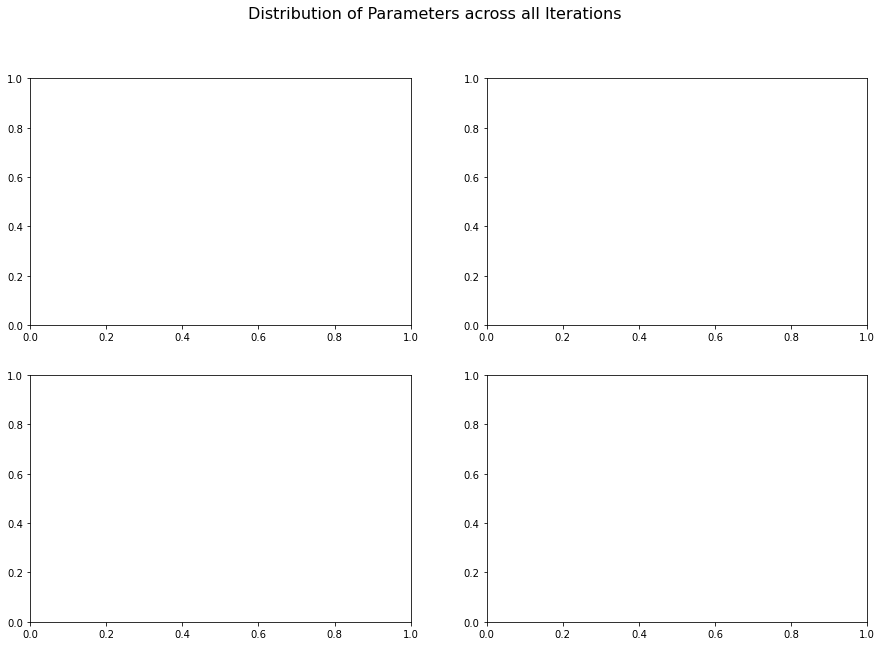

In [18]:
def annotate_percentage(ax, n, bins, patches):
    """Annotate histogram with percentage."""
    bin_width = bins[1] - bins[0]
    total = sum(n)  # Corrected this line
    for patch in patches:
        height = patch.get_height()
        percent = height / total
        
        if percent < 0.01:
            continue 
            
        ax.annotate(f"{percent:.1%}",
                    (patch.get_x() + bin_width / 2., height),
                    ha='center', va='center',
                    xytext=(0, 5),
                    textcoords='offset points')

# Extract unique values for each parameter from the original dataset
unique_values = {param: df_simulations[param].unique() for param in params}

# Plotting
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
fig.suptitle('Distribution of Parameters across all Iterations', fontsize=16)

params_list = ['init_delta_t', 'init_sigma_position_memory', 'weight_memory_decay', 'spatial_dist_coeff']
for ax, param in zip(axes.flatten(), params_list):
    n, bins, patches = ax.hist(best_params_df[param], bins=30, edgecolor='black', alpha=0.7)
    ax.set_title(param)
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    
    # Set x-ticks as unique values
    ax.set_xticks(unique_values[param])
    ax.tick_params(axis='x', rotation=45)
    
    # Annotate percentage
    annotate_percentage(ax, n, bins, patches)

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()


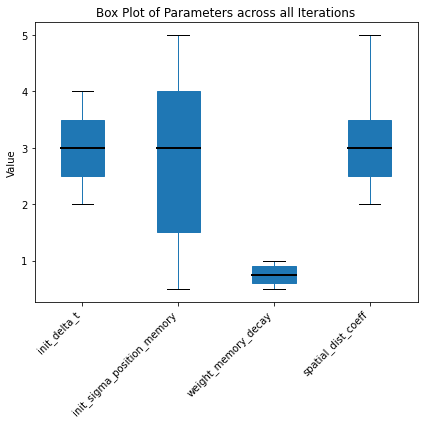

In [53]:
# Original distribution

medianprops = dict(linestyle='-', linewidth=2, color='black')  # Modify as per your color choice

fig, ax = plt.subplots(figsize=(6, 6))

# Box plot for all parameters
boxplot = best_params_df.boxplot(column=params_list, ax=ax, patch_artist=True, grid=False, medianprops=medianprops)

colors = ['lightblue', 'lightgreen', 'lightpink', 'lightyellow']  # Example colors

for patch, color in zip(ax.patches, colors):  # Access patches from ax
    patch.set_facecolor(color)

ax.set_title('Box Plot of Parameters across all Iterations')
ax.set_ylabel('Value')
ax.set_xticklabels(params_list, rotation=45, ha="right")

plt.tight_layout()
plt.show()

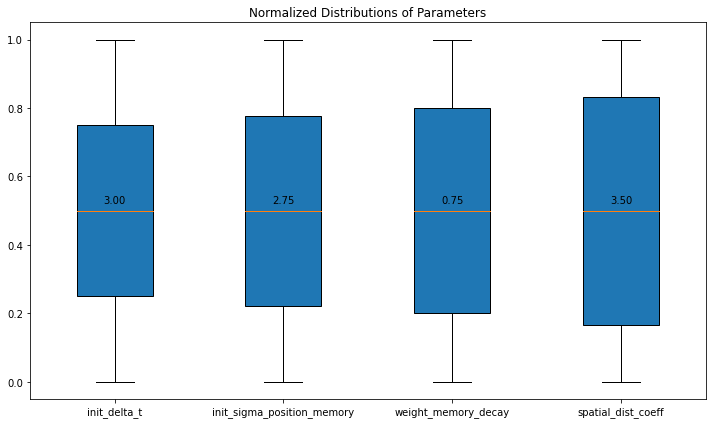

In [54]:
# Noralized box distribution

def normalize_series(series):
    """Normalize a pandas series to [0, 1] scale."""
    min_val = series.min()
    max_val = series.max()
    return (series - min_val) / (max_val - min_val)

# Normalize each parameter distribution
normalized_params_data = {
    param: normalize_series(df_simulations[param])
    for param in params.keys()
}

# Create boxplot for normalized data
fig, ax = plt.subplots(figsize=(10, 6))
ax.boxplot(normalized_params_data.values(), vert=True, patch_artist=True)

# Label the boxplots
ax.set_xticklabels(normalized_params_data.keys())

# Annotate with original median values
for i, param in enumerate(params.keys(), start=1):
    median_value = df_simulations[param].median()
    ax.annotate(f"{median_value:.2f}",
                (i, 0.5),  # Annotate at the center of each box. Adjust y-value as needed.
                ha='center', va='center',
                xytext=(0, 10),
                textcoords='offset points')

ax.set_title("Normalized Distributions of Parameters")
plt.tight_layout()
plt.show()


## Get data with only one iteration, like individual showcases

In [141]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
# Read in data
individual_data = r"C:\Users\91584\Desktop\0817_0630_selection_individual_data.csv"

individual_df = pd.read_csv(individual_data)

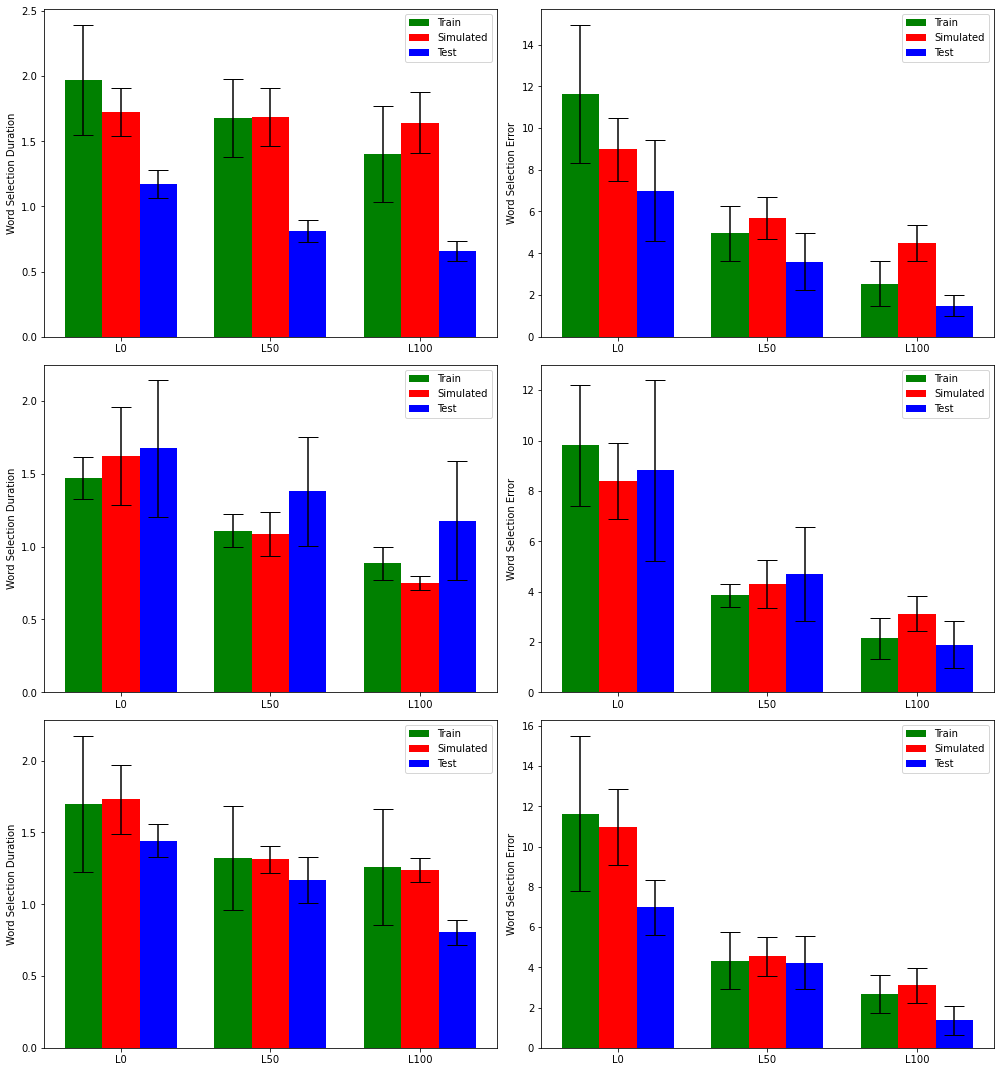

In [147]:
def extract_data(df, params, col_name, layouts):
    # Filter the dataframe based on the provided params
    for key, value in params.items():
        if isinstance(value, float):
            df = df[np.isclose(df[key], value, atol=1e-8)]
        else:
            df = df[df[key] == value]
    
    data = []
    for layout in layouts:
        subset = df[df['layout'] == layout][col_name].tolist()
        data.append(subset)
    return data

def calculate_mean_and_sem(data):
    means = [np.mean(d) for d in data]
    sems = [np.std(d) / np.sqrt(len(d)) for d in data]
    return means, sems

def plot_iteration(iteration_index):
    fig, axs = plt.subplots(3, 2, figsize=(14, 15))
    
    labels = ['L0', 'L50', 'L100']
    x = np.arange(len(labels))
    width = 0.25

    for i in range(3):
        iteration_index = i
        
        train_durations = [human_train_durations_details_copy[label][iteration_index] for label in labels]
        mean_train_duration, sem_train_duration = calculate_mean_and_sem(train_durations)
        
        test_durations = [human_test_durations_details_copy[label][iteration_index] for label in labels]
        mean_test_duration, sem_test_duration = calculate_mean_and_sem(test_durations)
        
        sim_durations = extract_data(individual_df, all_best_params[iteration_index], 'steps', layouts)
        adjusted_sim_durations = [[item * sim_to_real_ratios_duration[iteration_index] for item in sublist] for sublist in sim_durations]
        mean_sim_duration, sem_sim_duration = calculate_mean_and_sem(adjusted_sim_durations)
        
        train_errors = [human_train_errors_details_copy[label][iteration_index] for label in labels]
        mean_train_error, sem_train_error = calculate_mean_and_sem(train_errors)
        
        test_errors = [human_test_errors_details_copy[label][iteration_index] for label in labels]
        mean_test_error, sem_test_error = calculate_mean_and_sem(test_errors)
        
        sim_errors = extract_data(individual_df, all_best_params[iteration_index], 'error', layouts)
        adjusted_sim_errors = [[item * sim_to_real_ratios_error[iteration_index] for item in sublist] for sublist in sim_errors]
        mean_sim_error, sem_sim_error = calculate_mean_and_sem(adjusted_sim_errors)
        
        # Duration plots
        axs[i, 0].bar(x - width, mean_train_duration, width, label='Train', color='green', yerr=sem_train_duration, capsize=10)
        axs[i, 0].bar(x, mean_sim_duration, width, label='Simulated', color='red', yerr=sem_sim_duration, capsize=10)
        axs[i, 0].bar(x + width, mean_test_duration, width, label='Test', color='blue', yerr=sem_test_duration, capsize=10)
        
        axs[i, 0].set_ylabel('Word Selection Duration')
        axs[i, 0].set_xticks(x)
        axs[i, 0].set_xticklabels(labels)
        axs[i, 0].legend()

        # Error plots
        axs[i, 1].bar(x - width, mean_train_error, width, label='Train', color='green', yerr=sem_train_error, capsize=10)
        axs[i, 1].bar(x, mean_sim_error, width, label='Simulated', color='red', yerr=sem_sim_error, capsize=10)
        axs[i, 1].bar(x + width, mean_test_error, width, label='Test', color='blue', yerr=sem_test_error, capsize=10)
        
        axs[i, 1].set_ylabel('Word Selection Error')
        axs[i, 1].set_xticks(x)
        axs[i, 1].set_xticklabels(labels)
        axs[i, 1].legend()

    fig.tight_layout()
    plt.show()

# Plot for iteration 3
plot_iteration(3)